# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

Columns in DataFrame:
Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Host Id                     30478 non-null  int64  
 1   Host Since                  30475 non-null  object 
 2   Name                        30478 non-null  object 
 3   Neighbourhood               30478 non-null  object 
 4   Property Type               30475 non-null  object 
 5   Review Scores Rating (bin)  22155 non-null  float64
 6   Room Type                   30478 non-null  object 
 7   Zipcode                     30344 non-null  float64
 8   Beds         

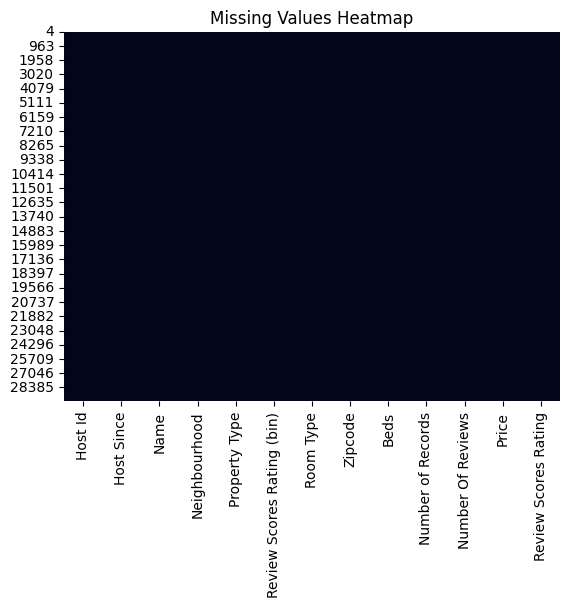

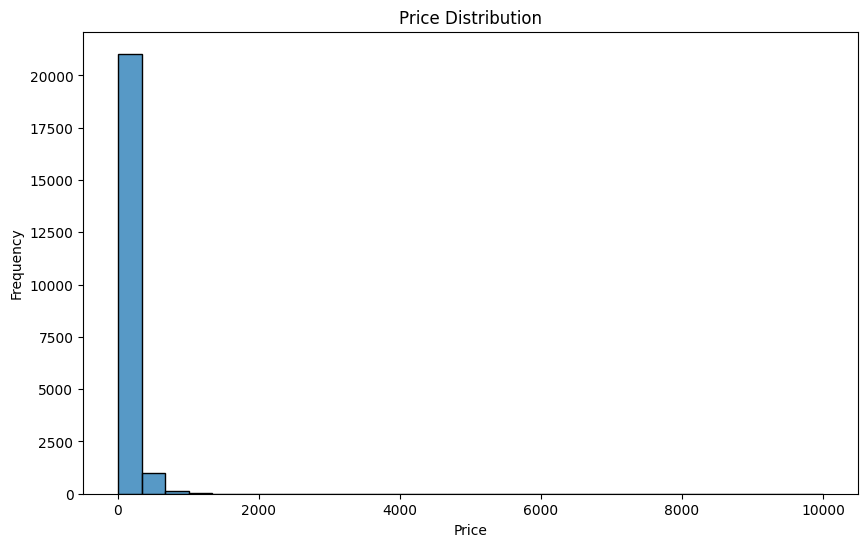

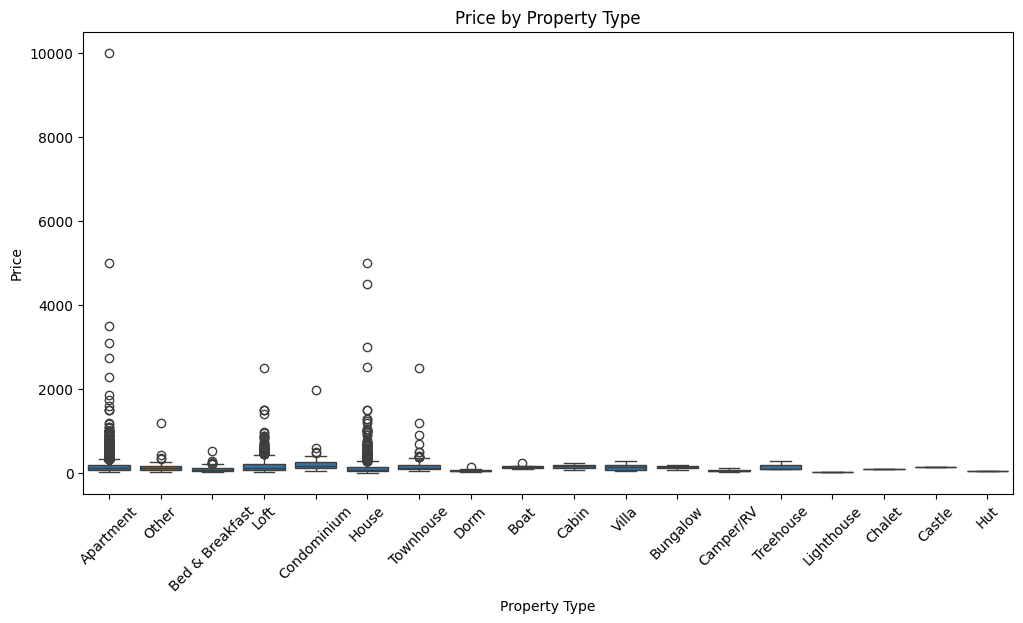

In [2]:
# 1) Data Cleaning/EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Load the Data
df = pd.read_csv('/content/airbnb_hw (1).csv')

# Data Cleaning
print("Columns in DataFrame:")
print(df.columns)

print("\nInitial DataFrame Info:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows with critical missing values
df.dropna(subset=['Price', 'Review Scores Rating'], inplace=True)

# Fill missing values for numeric columns with mean
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].mean())

# Clean the Price column by removing commas and converting to float
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Handle other categorical variables
for col in ['Property Type', 'Room Type', 'Neighbourhood']:
    if col in df.columns:
        df[col] = df[col].str.strip()

# Visualize missing values
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

# EDA
# Visualizing the Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Boxplot for Price vs. Property Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Property Type', y='Price', data=df)
plt.title('Price by Property Type')
plt.xticks(rotation=45)
plt.show()

# 2) Transforming categorical variables
df = pd.get_dummies(df, drop_first=True)

# 3) Train-Test Split
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# 4) Simple Linear Model
from sklearn.linear_model import LinearRegression, Lasso  # Importing LinearRegression
simple_model = LinearRegression()
simple_model.fit(X_train, y_train)

# Predictions and RMSE for simple model
y_train_pred = simple_model.predict(X_train)
y_test_pred = simple_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Simple Model Train RMSE: {rmse_train}')
print(f'Simple Model Test RMSE: {rmse_test}')

from sklearn.metrics import r2_score
print(f"Simple Model Train R²: {r2_score(y_train, y_train_pred)}")
print(f"Simple Model Test R²: {r2_score(y_test, y_test_pred)}")

Simple Model Train RMSE: 1.6859560659170236
Simple Model Test RMSE: 104.5443265220644
Simple Model Train R²: 0.9998827977374898
Simple Model Test R²: 0.2048742275427724


My simple training model does the best because it has a higher R^2 and lower RMSE.

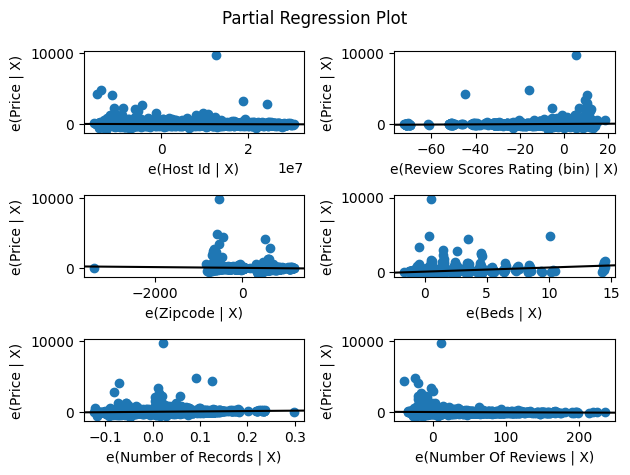

In [5]:
# 5) Partial Correlation Plots
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid

# Select only a few numeric variables (like 4-6) to avoid overloading the plot
numeric_cols = X_train.select_dtypes(include=np.number).columns

selected_cols = numeric_cols[:6]  # or: ['Bedrooms', 'Bathrooms', 'Review Scores Rating', etc.]

# Add a constant for the intercept
X_subset = sm.add_constant(X_train[selected_cols])

# Fit the statsmodels OLS model
model = sm.OLS(y_train, X_subset).fit()

# Generate the partial regression plots
plot_partregress_grid(model)
plt.tight_layout()
plt.show()


In [ ]:
# 6) Building a More Complex Model
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)  # Adjust degree as needed
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

complex_model = LinearRegression()
complex_model.fit(X_train_poly, y_train)

# Predictions and RMSE for complex model
y_train_poly_pred = complex_model.predict(X_train_poly)
y_test_poly_pred = complex_model.predict(X_test_poly)

rmse_train_poly = np.sqrt(mean_squared_error(y_train, y_train_poly_pred))
rmse_test_poly = np.sqrt(mean_squared_error(y_test, y_test_poly_pred))

print(f'Complex Model Train RMSE: {rmse_train_poly}')
print(f'Complex Model Test RMSE: {rmse_test_poly}')

print(f"Complex Model Train R²: {r2_score(y_train, y_train_poly_pred)}")
print(f"Complex Model Test R²: {r2_score(y_test, y_test_poly_pred)}")

# 7) Summary of Results
print("\nSummary of RMSE Results:")
print(f"Simple Model RMSE: Train - {rmse_train}, Test - {rmse_test}")
print(f"Complex Model RMSE: Train - {rmse_train_poly}, Test - {rmse_test_poly}")

# Overfitting and Underfitting Observations
if rmse_train_poly < rmse_train and rmse_test_poly > rmse_test:
    print("The complex model shows signs of overfitting.")
elif rmse_train_poly > rmse_train and rmse_test_poly < rmse_test:
    print("The complex model shows signs of underfitting.")
else:
    print("The models seem to fit well without evident overfitting or underfitting.")

# 8) Lasso Regularization
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Predictions and RMSE for Lasso model
lasso_y_train_pred = lasso_model.predict(X_train)
lasso_y_test_pred = lasso_model.predict(X_test)

lasso_rmse_train = np.sqrt(mean_squared_error(y_train, lasso_y_train_pred))
lasso_rmse_test = np.sqrt(mean_squared_error(y_test, lasso_y_test_pred))

print(f'Lasso Model Train RMSE: {lasso_rmse_train}')
print(f'Lasso Model Test RMSE: {lasso_rmse_test}')

print(f"Lasso Model Train R²: {r2_score(y_train, lasso_y_train_pred)}")
print(f"Lasso Model Test R²: {r2_score(y_test, lasso_y_test_pred)}")

# Selected features by Lasso
selected_features = X.columns[lasso_model.coef_ != 0]
print("Selected features by Lasso:", selected_features)

# I used StackOverflow, Open AI, and class notes to help with this assignment.